# Classification using CLIP Model

#### Imports

In [101]:
import torch
import numpy as np
import pandas as pd

In [2]:
import cv2
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as alb

In [3]:
import os
from os import listdir
from os.path import isfile, join

In [4]:
from transformers import DistilBertTokenizer

In [5]:
from src.models.clip_model import CLIPModel
from src.utils import get_config
from src.data_utils.dataset import ImgTextDataset

In [6]:
global_config = get_config()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Tokenizer and data loader

Here use two different datasets, as the pair Inage-text won't work.
* We have a set of captions that are nothing but modified prompts with class label
* For each image, we get the similarity between the image and the caption.
* The caption with highest probability is termed is final label

In [8]:
class ImgDataset(Dataset):
    def __init__(self, image_dir, image_filenames):
        self.image_dir = image_dir
        self.image_filenames = image_filenames
        self.transforms = self._data_transforms()

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.image_filenames[index])
        # using cv2 for image reading which is claimed to be faster than PIL based pytorch one
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item = dict({
            "image": torch.tensor(image).permute(2, 0, 1).float(),
        })
        return item

    def __len__(self):
        return len(self.image_filenames)

    @staticmethod
    def _data_transforms():
        """albumentations performs better than torch transforms"""
        transformations = alb.Compose(
            [
                alb.Resize(global_config['data_config']['image_size'],
                           global_config['data_config']['image_size'],
                           always_apply=True),
                alb.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
        return transformations

In [9]:
class TextDataset(Dataset):
    def __init__(self, captions, tokenizer):
        self.captions = captions
        self.encoded_captions = tokenizer(
            captions.tolist(),
            padding=True, truncation=True,
            return_tensors='pt',
            max_length=global_config['model_config']['text_model']['max_length'])
        self.tokenizer = tokenizer

    def __getitem__(self, index):
        item = dict({
            "caption": self.captions[index],
            "input_ids": self.encoded_captions['input_ids'][index],
            "attention_masks": self.encoded_captions['attention_mask'][index]
        })
        return item

    def __len__(self):
        return len(self.captions)

In [10]:
tokenizer = DistilBertTokenizer.from_pretrained(global_config['model_config']['text_model']['text_tokenizer'])

In [77]:
image_folder = "../data/seg_test/seg_test/mixed/"

In [106]:
captions = np.array(["a tall building with view of sky",
            "a busy street with people and cars",
            "sea shore with pebbles",
            "a photo of a summit",
            "a photo of a raging water",
             "dense forest with trees"])

In [107]:
image_files = [f for f in listdir(image_folder) if isfile(join(image_folder, f))]

img_dataset = ImgDataset(image_folder, image_files)

img_data_loader = DataLoader(img_dataset, batch_size=32, shuffle=True)

In [108]:
text_dataset = TextDataset(captions, tokenizer)

text_data_loader = DataLoader(text_dataset, batch_size=32, shuffle=True)

### Model loading

Loading the previously model

In [109]:
model = CLIPModel().to(device)

In [110]:
model_path = "../best.pt"

In [111]:
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [112]:
model.eval()

CLIPModel(
  (image_encoder): ImageTower(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Model inference 

In [113]:
from tqdm import tqdm

In [114]:
valid_text_embeddings = []
with torch.no_grad():
    for batch in tqdm(text_data_loader):
        batch = {k: v.to(device) for k,v in batch.items() if k!='caption'}
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_masks"]
        )
        text_embeddings = model.text_projection_head(text_features)
        valid_text_embeddings.append(text_embeddings)
text_embeddings = torch.cat(valid_text_embeddings)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


In [115]:
cur_image = iter(img_data_loader).next()

In [116]:
valid_image_embeddings = []
with torch.no_grad():
    image_features = model.image_encoder(cur_image['image'].to(device))
    image_embeddings = model.image_projection_head(image_features)
    valid_image_embeddings.append(image_embeddings)
valid_image_embeddings = torch.cat(valid_image_embeddings)

In [117]:
image_embeddings_n = F.normalize(valid_image_embeddings, p=2, dim=-1)

In [118]:
text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

In [119]:
image_embeddings_n.shape

torch.Size([32, 256])

In [120]:
text_embeddings_n.shape

torch.Size([6, 256])

In [121]:
dot_similarity = image_embeddings_n  @ text_embeddings_n.T

In [122]:
pd.DataFrame(dot_similarity.to("cpu"), columns=captions)

,a tall building with view of sky,a busy street with people and cars,sea shore with pebbles,a photo of a summit,a photo of a raging water,dense forest with trees
0,tensor(0.5126),tensor(0.5146),tensor(0.5803),tensor(0.5265),tensor(0.5951),tensor(0.4359)
1,tensor(0.5052),tensor(0.4518),tensor(0.5032),tensor(0.4987),tensor(0.5157),tensor(0.4265)
2,tensor(0.4867),tensor(0.5153),tensor(0.5565),tensor(0.5014),tensor(0.5924),tensor(0.4468)
3,tensor(0.5674),tensor(0.5480),tensor(0.5489),tensor(0.5655),tensor(0.5132),tensor(0.5369)
4,tensor(0.4443),tensor(0.5084),tensor(0.4817),tensor(0.3735),tensor(0.4892),tensor(0.5221)
5,tensor(0.2798),tensor(0.2502),tensor(0.3636),tensor(0.3305),tensor(0.4354),tensor(0.1401)
6,tensor(0.4162),tensor(0.4645),tensor(0.4587),tensor(0.3829),tensor(0.5261),tensor(0.4251)
7,tensor(0.4183),tensor(0.4165),tensor(0.4263),tensor(0.4098),tensor(0.4821),tensor(0.3754)
8,tensor(0.3374),tensor(0.4117),tensor(0.3867),tensor(0.2516),tensor(0.4099),tensor(0.4389)
9,tensor(0.3555),tensor(0.3810),tensor(0.4294),tensor(0.3904),tensor(0.4776),tensor(0.2684)


In [123]:
dot_similarity.shape

torch.Size([32, 6])

In [124]:
_, indices = torch.topk(dot_similarity.squeeze(0), 1)

In [125]:
indices = indices.reshape(-1)

In [126]:
matches = [captions[idx] for idx in indices]

In [127]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


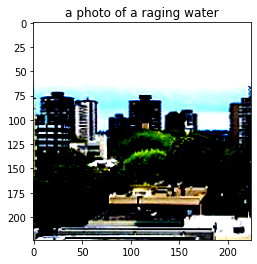

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


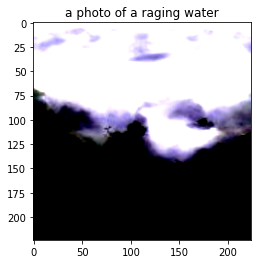

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


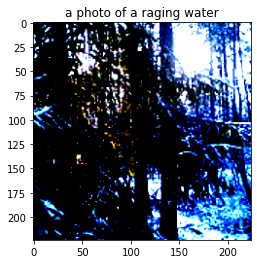

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


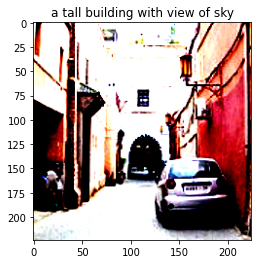

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


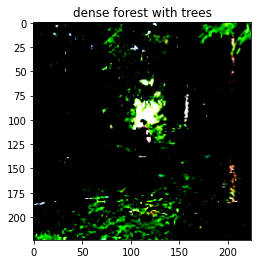

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


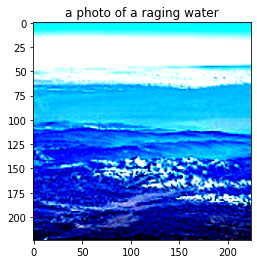

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


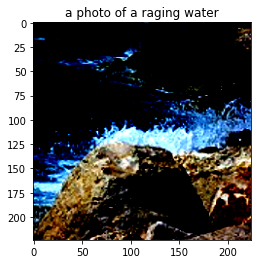

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


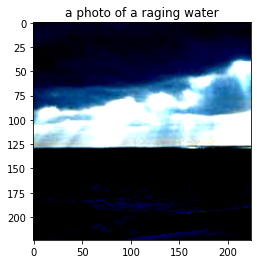

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


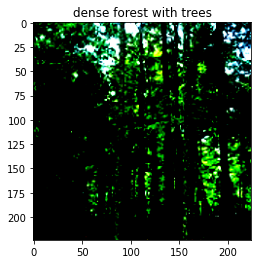

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


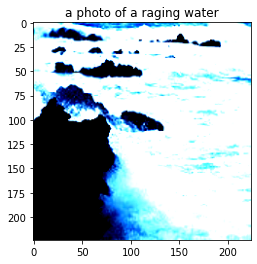

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


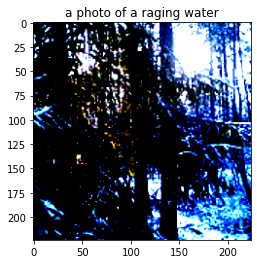

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


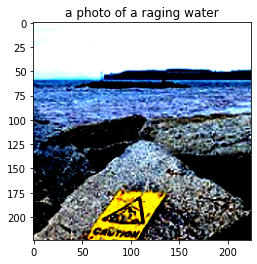

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


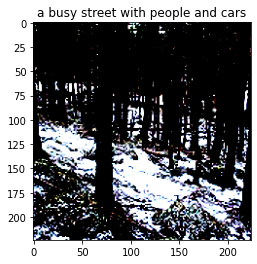

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


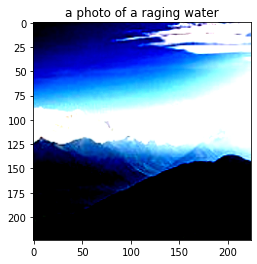

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


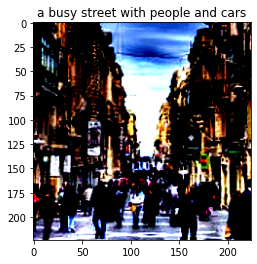

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


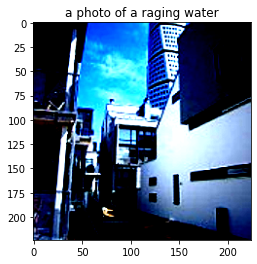

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


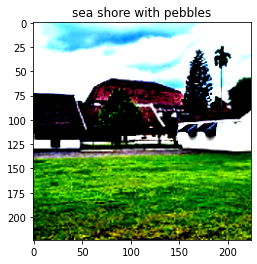

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


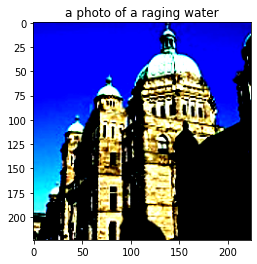

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


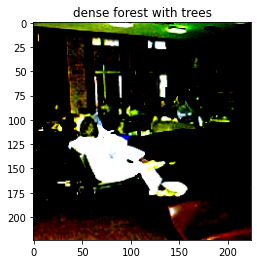

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


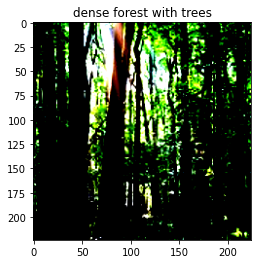

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


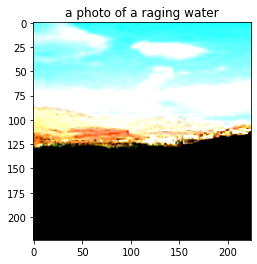

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


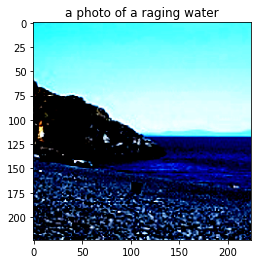

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


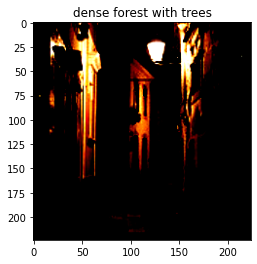

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


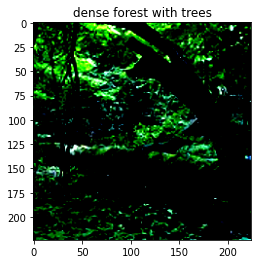

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


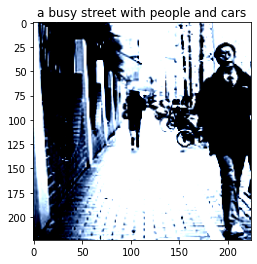

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


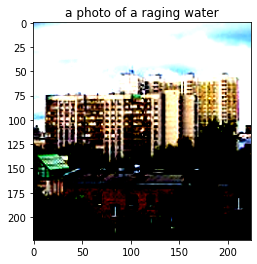

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


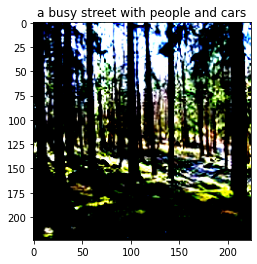

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


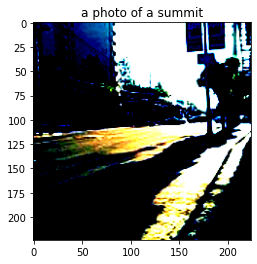

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


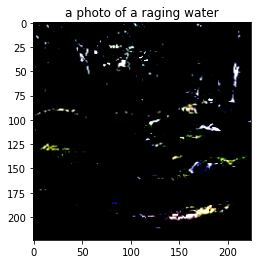

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


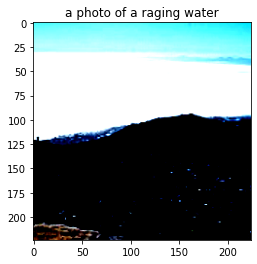

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


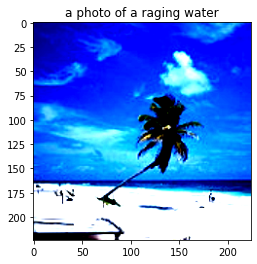

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


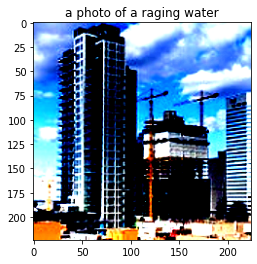

In [128]:
for img, label in zip(cur_image['image'], matches):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.show()